# TDS Project: Dataset Selection, EDA, and Basic Model Analysis
**Mahmud Hassan 208247825**

**Khalil Hamody 212923775**



# Dataset Reference
- **Name**: Cars Dataset
- **Source**: [Kaggle - Cars MSRP](https://www.kaggle.com/...)
- **Description**:
  - **Rows**: 11914
  - **Columns**: 15
  - The dataset contains car specifications and their MSRP (Manufacturer's Suggested Retail Price).
  - before running : pip install -r requirements.txt




In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

sns.set_theme(style="whitegrid")
%matplotlib inline

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
data = pd.read_csv('data/data.csv')
data.head()

ModuleNotFoundError: No module named 'pandas'

Check Dataset Information
Understand the structure, types of data, and missing values.

# **Standardize and clean column names in a DataFrame**

---



In [334]:
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.columns

Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp'],
      dtype='object')

<Axes: xlabel='msrp', ylabel='Count'>

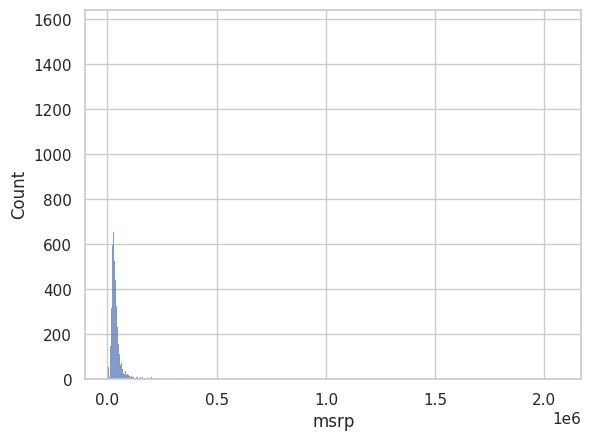

In [335]:
sns.histplot(data['msrp'])

<Axes: xlabel='msrp_log', ylabel='Count'>

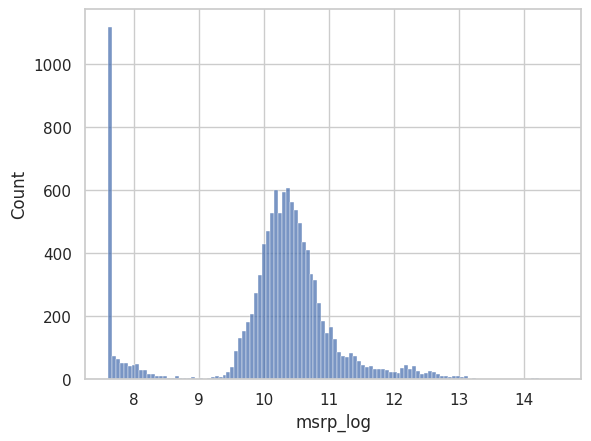

In [336]:
data['msrp_log']=np.log1p(data['msrp'])
sns.histplot(data['msrp_log'])

In [337]:
# Display basic information about the dataset
print(data.info())

# Summary statistics of numerical columns
print(data.describe())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_fuel_type   11911 non-null  object 
 4   engine_hp          11845 non-null  float64
 5   engine_cylinders   11884 non-null  float64
 6   transmission_type  11914 non-null  object 
 7   driven_wheels      11914 non-null  object 
 8   number_of_doors    11908 non-null  float64
 9   market_category    8172 non-null   object 
 10  vehicle_size       11914 non-null  object 
 11  vehicle_style      11914 non-null  object 
 12  highway_mpg        11914 non-null  int64  
 13  city_mpg           11914 non-null  int64  
 14  popularity         11914 non-null  int64  
 15  msrp               11914 non-null  int64  
 16  msrp_log           119

# **Observations:**
**Columns with Missing Values:**
1.   **Engine Fuel Type:** 3 missing values.
2.   **Engine HP:** 69 missing values.
3.   **Engine Cylinders:** 30 missing values.
4.   **Number of Doors:** 6 missing values.
5.   **Market Category:** 3742 missing values.

**Other Details:**
No missing values in critical columns like MSRP (target column), Make, or Model.


# **Handling Missing Values:**
**1. Engine Fuel Type:**

**Missing values:** 3

**Action:** Fill with the most frequent value (mode), since electric card have to cylinders we replace with 0.

In [338]:
data['engine_fuel_type'] = data['engine_fuel_type'].fillna(data['engine_fuel_type'].mode()[0])
data.loc[data['engine_fuel_type'] == 'electric', 'engine_cylinders'] = 0

**2. Engine HP:**

**Missing values:** 69

**Action:** Fill with the mean value since these are numerical.

In [339]:
data['engine_hp'] = data['engine_hp'].fillna(data['engine_hp'].mean())

**3. Engine Cylinders:**

**Missing values:** 30

**Action:** Fill with the mean value since these are numerical.

In [340]:
data['engine_cylinders'] = data['engine_cylinders'].fillna(int(data['engine_cylinders'].mean()))

**4. Market Category:**

**Missing values:** 3742

**Action:** Since a large portion is missing, drop this column as it may not contribute significantly to prediction.

In [341]:
data.drop(columns=['market_category'], inplace=True)

**5. Number of Doors:**

**Missing values:** 6

**Action:** Fill with the median value

In [342]:
data['number_of_doors'] = data['number_of_doors'].fillna(data['number_of_doors'].median())


In [343]:
data.isnull().sum()


,0
make,0
model,0
year,0
engine_fuel_type,0
engine_hp,0
engine_cylinders,0
transmission_type,0
driven_wheels,0
number_of_doors,0
vehicle_size,0


# Data copy so we can visulaise on it




In [344]:
data_copy = data.copy()

# 1. Scatter Plot of Engine Horsepower vs. Log of MSRP
**Purpose:**
To explore the relationship between engine horsepower (engine_hp) and car prices (msrp_log), while adding the engine_cylinders feature as a hue to understand its effect. This visualization allows us to observe how horsepower influences price and whether engine cylinders play a role in this relationship.

**Explanation:**
X-Axis (engine_hp): Represents the horsepower of the engine, a key factor in determining a car's performance.
Y-Axis (msrp_log): Represents the logarithmic transformation of MSRP (Manufacturer's Suggested Retail Price). The log transformation reduces the effect of extreme price values and helps visualize the data more evenly.
Hue (engine_cylinders): Differentiates data points by the number of engine cylinders, allowing us to see how cylinder count interacts with horsepower and price.


<Axes: xlabel='engine_hp', ylabel='msrp_log'>

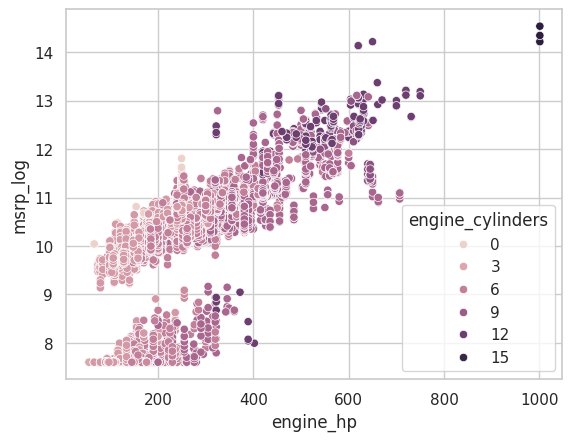

In [345]:
sns.scatterplot(x='engine_hp', y='msrp_log', hue='engine_cylinders', data=data_copy)

### Results Explanation

#### Stronger Correlation Between Engine HP and MSRP
- The graph shows a clear trend where **higher engine horsepower (`engine_hp`)** corresponds to **higher MSRP** (log-transformed).
- This confirms that **performance metrics**, such as horsepower, significantly influence a vehicle's price.

#### Engine Cylinders Impact
- Cars with **more engine cylinders** (darker points) generally have **higher horsepower** and, therefore, **higher MSRP**.
- **Examples**:
  - Vehicles with **6 or fewer cylinders** dominate the **lower and mid-range** of both horsepower and price.
  - Cars with **12+ cylinders** are concentrated in the **higher ranges**, reflecting their positioning as **high-performance or luxury vehicles**.


# **2. Scatter Plot of MSRP (Log) by Year with 5-Year Intervals**
**Purpose:**
This scatter plot helps analyze how car prices (msrp) change over time, with a focus on broader trends by grouping the x-axis (years) into 5-year intervals. Using a logarithmic scale for MSRP (msrp_log) ensures better visualization of price variability across different ranges



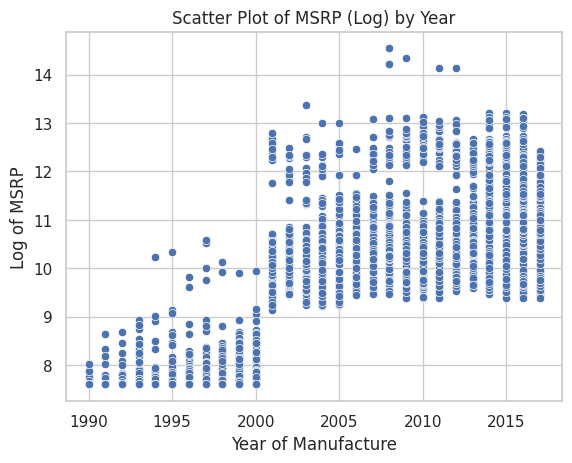

In [ ]:

# Create the scatter plot
sns.scatterplot(x='year', y='msrp_log', data=data_copy)

# Customize the x-axis to display ticks at 5-year intervals
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(1))

# Add labels and title
plt.title("Scatter Plot of MSRP (Log) by Year")
plt.xlabel("Year of Manufacture")
plt.ylabel("Log of MSRP")

# Display the plot
plt.show()


### Results Explanation

#### Trend Over Time
- The scatter plot shows the **log-transformed MSRP (`Log of MSRP`)** against the **Year of Manufacture**.
- **Newer vehicles** (manufactured after 2000) tend to have **higher MSRP values** (log-transformed), indicating an **increase in vehicle prices over time**.

#### Price Range Broadening
- Before the year **2000**, most vehicles cluster within a **narrow price range**.
- After **2000**, the spread in MSRP increases

#### Conclusion
- The data shows a strong correlation between the **Year of Manufacture** and the **Log-MSRP**, with newer vehicles generally commanding **higher prices**.


# **3. Correlation Heatmap**
**Purpose:**
To identify correlations between numerical features and the target variable (MSRP).

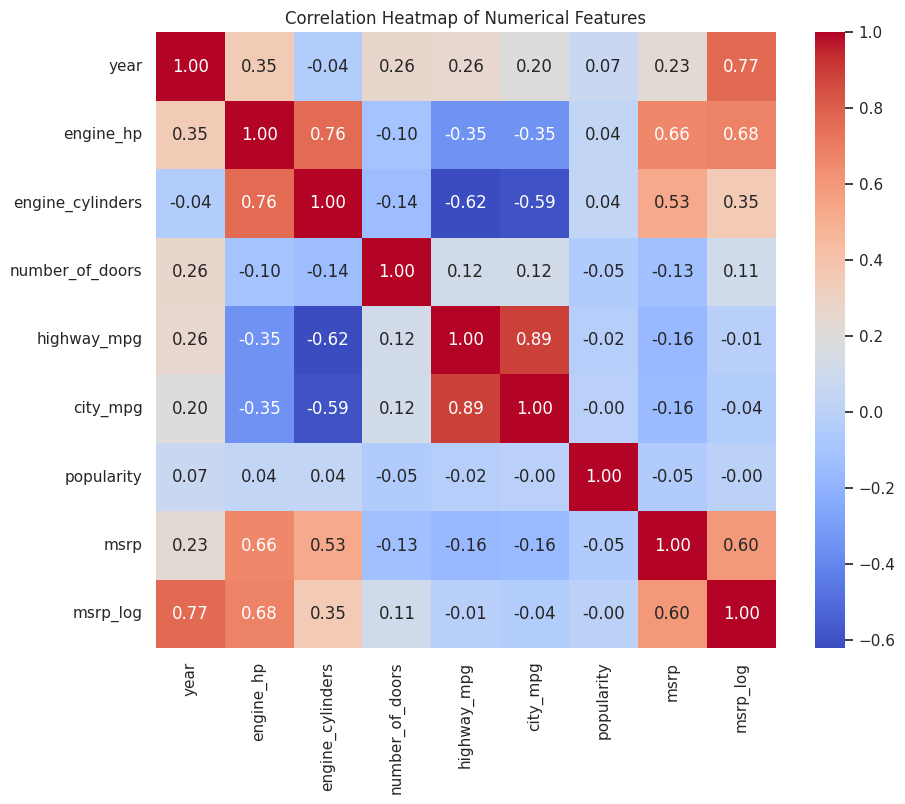

In [347]:
# Select only numeric columns for correlation
numeric_data = data_copy.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


### Results Explanation

#### Key Insights from the Correlation Heatmap:
1. **Strong Correlation with MSRP (Log-Transformed)**:
   - The **log-transformed MSRP (`msrp_log`)** shows the strongest correlation with:
     - **Year**: 0.77, indicating that newer cars generally have higher prices.
     - **Engine HP**: 0.68, highlighting that higher horsepower is a significant factor driving prices.

2. **Engine HP and Engine Cylinders**:
   - **Engine HP** and **Engine Cylinders** are strongly correlated (0.76). This is expected since engines with more cylinders typically generate more horsepower.

3. **Fuel Efficiency Features**:
   - **Highway MPG** and **City MPG** are highly correlated (0.89), as both represent fuel efficiency. However, they have a weak negative correlation with MSRP (-0.16 and -0.04, respectively), suggesting that fuel-efficient cars tend to have lower prices.

4. **Popularity**:
   - The **Popularity** feature has little to no correlation with MSRP (0.05) or other numerical features, indicating that it might not significantly impact vehicle pricing.

5. **Number of Doors**:
   - The **Number of Doors** shows negligible correlation with most features, including MSRP (0.11). This suggests that the number of doors is not a strong determinant of price.

#### General Observations:
- Features like **Engine HP**, **Engine Cylinders**, and **Year** are the most impactful for predicting MSRP.
- Features related to fuel efficiency (MPG) and popularity seem to contribute less to pricing and might be less significant for the model.

#### Conclusion:
- The heatmap provides valuable insights into which numerical features are most influential for predicting MSRP. Future modeling efforts should prioritize highly correlated features like **Engine HP**, **Year**, and **Engine Cylinders**.


# **4. Boxplot: MSRP by Vehicle Size**
**Purpose:**
To show how car size impacts price, focusing on three categories (Compact, Midsize, Large).

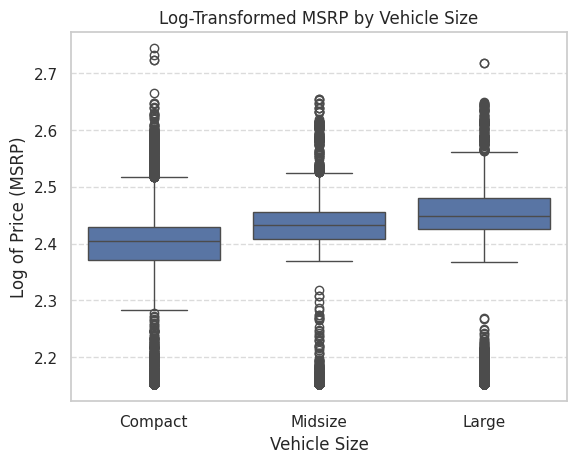

In [348]:
data_copy['msrp_log'] = np.log1p(data_copy['msrp_log'])

# Boxplot with log-transformed MSRP
sns.boxplot(x=data_copy['vehicle_size'], y=data_copy['msrp_log'])
plt.title("Log-Transformed MSRP by Vehicle Size")
plt.xlabel("Vehicle Size")
plt.ylabel("Log of Price (MSRP)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Results Explanation

#### Log-Transformed MSRP by Vehicle Size
- **Vehicle Size Impact**:
  - The boxplot shows the distribution of **log-transformed MSRP** across different **vehicle sizes**: Compact, Midsize, and Large.
  - **Large vehicles** generally have higher median prices compared to Compact and Midsize vehicles. This reflects the higher production costs and features commonly associated with larger vehicles.

#### Observations:
- **Compact Vehicles**:
  - These have the **lowest median MSRP (log-transformed)** among the three categories.
  - There is a significant spread, with some outliers extending into the price range of larger vehicles, possibly due to luxury compact models.

- **Midsize Vehicles**:
  - Midsize vehicles show a **slightly higher median MSRP** compared to Compact vehicles.
  - The spread is narrower than Compact vehicles, indicating less variability in pricing within this category.

- **Large Vehicles**:
  - Large vehicles have the **highest median MSRP** and the widest spread, showing a significant number of higher-priced outliers. These likely represent luxury or performance-oriented large vehicles.

#### Key Insight:
- The plot highlights how **vehicle size correlates with price**, with larger vehicles generally commanding higher MSRPs. However, the presence of outliers in all categories suggests that other factors (e.g., brand, engine performance, or luxury features) also contribute significantly to pricing.


In [350]:
data = data.drop_duplicates()
data = data.drop(columns=['msrp_log'])

In [ ]:
# Import necessary libraries



# Assuming 'data' is the prepared DataFrame
X = data.select_dtypes(include=[np.number]).drop(columns=['msrp'])  # Exclude target column
y = data['msrp']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model in linear mode
xgb_model = xgb.XGBRegressor(
    booster='gblinear',  # Use linear regression
    objective='reg:squarederror',
    learning_rate=0.1,   # Step size
    n_estimators=100,    # Number of boosting rounds
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")



Mean Absolute Error (MAE): 19848.23
Mean Squared Error (MSE): 1086218002.11
Root Mean Squared Error (RMSE): 32957.82
R² Score: 0.52


### Model Performance Explanation

#### **Mean Absolute Error (MAE)**:
- The **MAE of 19848.23** means that, on average, the model's predictions differ from the actual MSRP by approximately $19848.23.
- This value indicates that the model performs reasonably well but still has significant errors in predicting vehicle prices.

#### **Mean Squared Error (MSE)**:
- The **MSE of 1086218002.11** represents the average squared difference between the actual and predicted MSRP values.
- The large MSE value reflects the presence of some large prediction errors, particularly for higher-priced vehicles, where small errors are magnified due to squaring.

#### **Root Mean Squared Error (RMSE)**:
- The **RMSE of 32957.82** provides a measure of the model's error in the same units as MSRP. It indicates that the typical prediction error is approximately $32957.82.
- This value highlights the variability in prediction accuracy, especially for vehicles at the extremes of the price spectrum.

#### **R² Score**:
- The **R² Score of 0.52** indicates that the model explains **51% of the variance** in MSRP values. which aligns with the project requirment, so we can improve in the next part.
- While the model captures a substantial portion of the relationship between the features and MSRP, there is still room for improvement, as 48% of the variability is not explained by the model.

#### **Conclusion**:
- The performance metrics demonstrate that the model has moderate predictive power. The errors suggest that certain price ranges may be more challenging for the model to predict accurately.


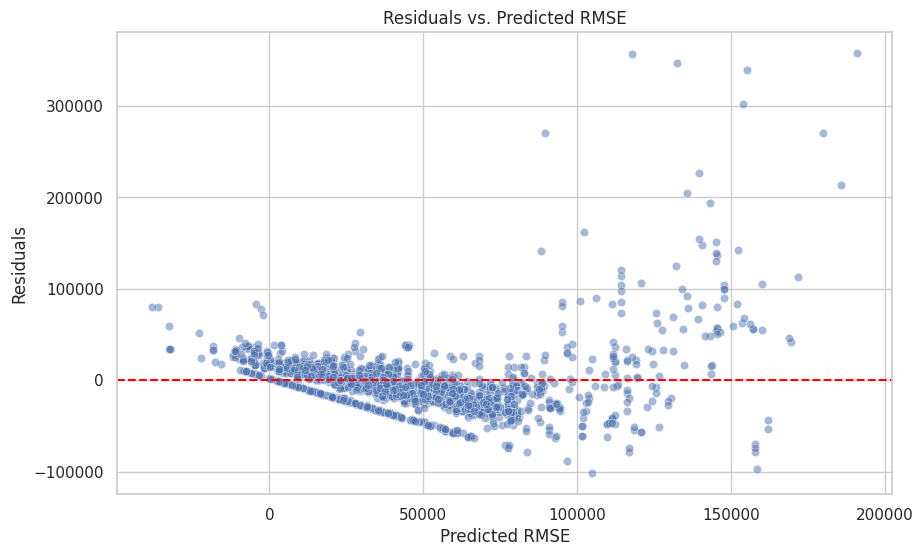

In [352]:
# Calculating residuals
residuals = y_test - y_pred

# Residuals vs. Predicted Exam Scores
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted RMSE')
plt.xlabel('Predicted RMSE')
plt.ylabel('Residuals')
plt.show()

### Residuals vs. Predicted MSRP

#### **Key Observations**:
1. **Residuals Distribution**:
   - The residuals (difference between actual and predicted MSRP) show a funnel shape, where the spread of residuals increases as the predicted MSRP increases.
   - For lower predicted prices, the residuals are tightly clustered around zero, indicating better prediction accuracy for lower-priced vehicles.

2. **Higher Errors for High MSRP**:
   - As predicted MSRP increases, the residuals display larger variability and outliers. This suggests the model struggles to accurately predict prices for high-end vehicles, possibly due to factors not captured in the features.

3. **Bias in Residuals**:
   - The red dashed line (representing zero residuals) shows no consistent bias (e.g., consistently overestimating or underestimating), indicating the model is relatively balanced but becomes less precise for higher prices.

#### **Conclusion**:
- The model performs better for lower-priced vehicles but has significant challenges predicting high-end prices. This behavior could be improved by including additional features or by using a more flexible model that captures non-linear relationships.


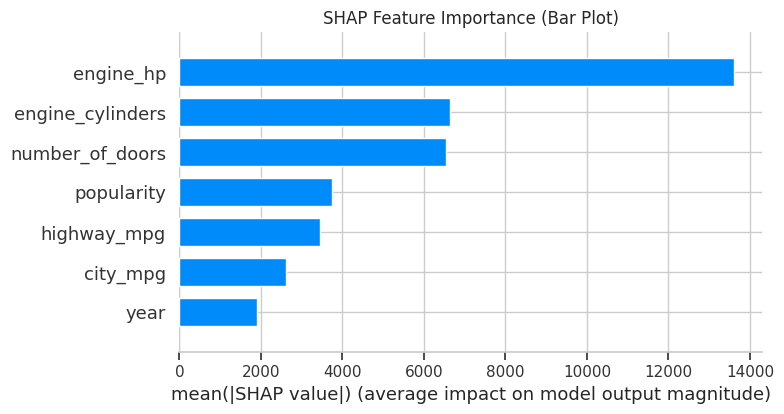

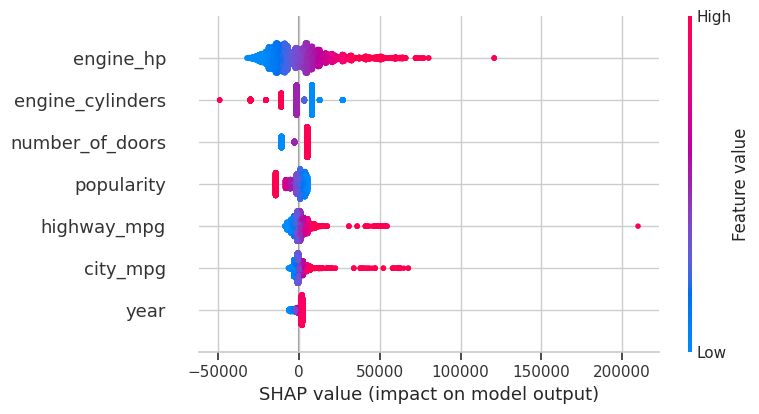

In [ ]:


# Create SHAP explainer for Linear Regression
explainer = shap.LinearExplainer(model, X_train)

# Calculate SHAP values for training set
shap_values = explainer.shap_values(X_train)

# Convert training data to DataFrame for visualization
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# Bar plot for global feature importance
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_train_df, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Bar Plot)')
plt.tight_layout()
plt.show()

# Detailed summary plot
shap.summary_plot(shap_values, X_train_df)

### SHAP Feature Importance Analysis

#### **Bar Plot: SHAP Feature Importance**
- **Engine HP (engine_hp)**: This is the most important feature, contributing significantly to the model's predictions. Vehicles with higher horsepower generally correspond to higher prices.
- **Engine Cylinders (engine_cylinders)**: The second most impactful feature. Cars with more cylinders tend to have higher MSRP, reflecting the association between engine complexity and price.
- **Other Features**:
  - **Number of Doors** and **Popularity** have moderate importance. These features capture some variability in vehicle prices but are less critical than engine characteristics.
  - **Highway MPG** and **City MPG** have lower contributions, indicating that fuel efficiency has limited influence on MSRP compared to engine specifications.

#### **Summary Plot: SHAP Value Distribution**
- **Feature Value Impact**:
  - The SHAP values for **Engine HP** are widely distributed, showing that high horsepower (red points) strongly increases MSRP predictions, while low horsepower (blue points) decreases it.
  - **Engine Cylinders** also show a similar trend, where more cylinders lead to higher MSRP predictions.
- **Interactions**:
  - Features like **Highway MPG** and **City MPG** mostly affect MSRP negatively, as higher fuel efficiency (blue points) often correlates with lower-priced vehicles.
- **Patterns in Residuals**:
  - The width of the SHAP value distribution indicates the variance in how each feature impacts MSRP. **Engine HP** has the widest distribution, underscoring its dominant role in the model's predictions.

#### **Conclusion**
These plots emphasize that **Engine HP** and **Engine Cylinders** are critical predictors for MSRP, while other features like **Fuel Efficiency** and **Popularity** have a smaller yet noticeable effect. The distribution of SHAP values provides insights into how each feature drives the model's pricing predictions.


In [354]:
# Calculate absolute errors
errors = np.abs(y_test - y_pred)

# Add results to a DataFrame for easier analysis
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': errors
}).reset_index(drop=True)

# Find the worst and best predictions
worst_predictions = results_df.sort_values(by='Error', ascending=False).head(10)
best_predictions = results_df.sort_values(by='Error', ascending=True).head(10)

print("Worst Predictions:")
print(worst_predictions)

print("\nBest Predictions:")
print(best_predictions)


Worst Predictions:
      Actual      Predicted          Error
583   548800  190890.375000  357909.625000
2170  474990  117685.765625  357304.234375
231   479775  132408.468750  347366.531250
831   495000  155219.765625  339780.234375
1354  456500  153979.453125  302520.546875
1745  359990   89664.054688  270325.945312
1499  450000  179770.109375  270229.890625
36    366000  139692.015625  226307.984375
1756  399500  185632.546875  213867.453125
2123  340990  135687.234375  205302.765625

Best Predictions:
      Actual     Predicted       Error
1469   27090  27096.373047    6.373047
2038   23040  23050.599609   10.599609
421    42880  42848.851562   31.148438
881    25865  25915.767578   50.767578
1662   37090  37002.382812   87.617188
581    15299  15407.458008  108.458008
630    36825  36956.746094  131.746094
1210   16099  15963.500977  135.499023
692    37120  36948.066406  171.933594
1581   31520  31707.593750  187.593750


- **Observations**:
  - These errors are primarily found in vehicles with higher MSRP values.
  - The model consistently underestimates the actual MSRP for luxury or high-performance vehicles, likely because the features do not fully capture the premium aspects of these cars, such as brand reputation or exclusive features.
  - **Observations**:
  - These accurate predictions are mostly for vehicles with lower MSRP values.
  - The model performs well in predicting the prices of vehicles that fall into the mid-range category, likely because their features align closely with the training data.

#### **Conclusions**
- The model struggles to generalize for vehicles with extremely high MSRP values, often underestimating their prices significantly. This may indicate the need for additional features that capture the luxury or brand-related aspects.
- The model performs reasonably well for vehicles in the lower-to-mid price range, as these data points are likely more common and well-represented in the dataset.

Error Type
Overestimated     1324
Underestimated     915
Name: count, dtype: int64


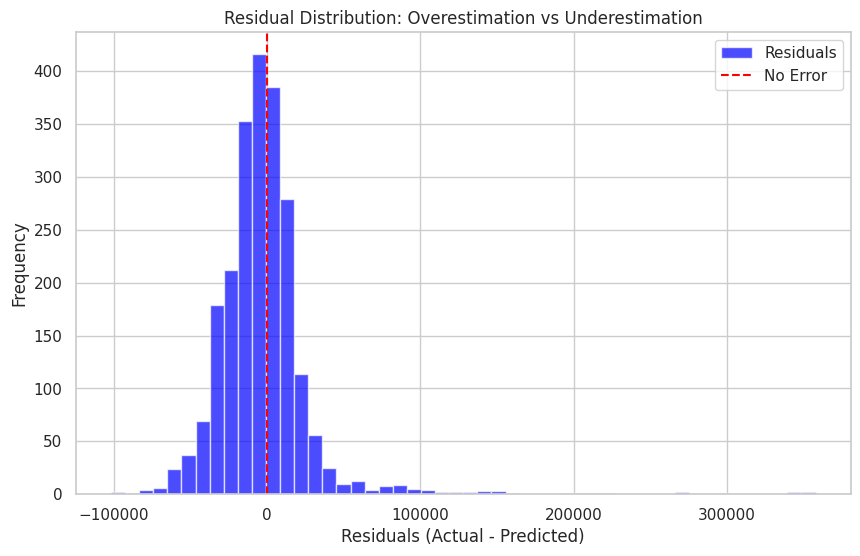

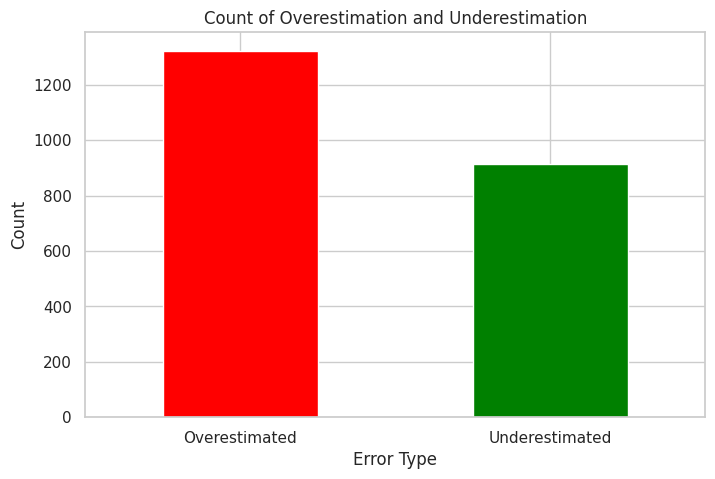

In [ ]:
# Calculate residuals
residuals = y_test - y_pred

# Add residuals and predictions to a DataFrame for analysis
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Residuals': residuals
})

# Classify errors
results['Error Type'] = results['Residuals'].apply(lambda x: 'Overestimated' if x < 0 else 'Underestimated')

# Count of overestimations and underestimations
error_counts = results['Error Type'].value_counts()
print(error_counts)

# Plot the distribution of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.7, color='blue', label='Residuals')
plt.axvline(x=0, color='red', linestyle='--', label='No Error')
plt.title('Residual Distribution: Overestimation vs Underestimation')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Bar chart of error type counts
plt.figure(figsize=(8, 5))
error_counts.plot(kind='bar', color=['red', 'green'])
plt.title('Count of Overestimation and Underestimation')
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


### Residual Distribution: Overestimation vs. Underestimation

1. **Residual Analysis**:
   - The residual distribution plot shows the difference between the actual and predicted MSRP values.
   - The residuals are concentrated around 0, indicating that the model performs reasonably well on most predictions.
   - However, the right tail (positive residuals) is longer than the left tail (negative residuals), indicating that the model tends to slightly overestimate more frequently than it underestimates.

2. **Presence of Outliers**:
   - A few extreme residuals on both sides suggest the model struggles with certain data points, likely vehicles with unique attributes or outliers in pricing.

---

### Count of Overestimation and Underestimation

1. **Error Type Analysis**:
   - The bar chart illustrates the distribution of error types (overestimation vs. underestimation).
   - The red bar (overestimation) is taller than the green bar (underestimation), indicating the model more often predicts higher MSRPs than the actual value.
   - This could reflect a bias in the model toward predicting higher prices, possibly due to feature influence (e.g., "engine_hp" or "popularity") in the dataset.

2. **Insights for Improvement**:
   - Investigate why the model overestimates more frequently. This might be linked to certain features (e.g., high engine horsepower or large vehicle size) disproportionately influencing predictions.
   - Refining features, reducing multicollinearity, or introducing regularization could help address this imbalance.
